In [1]:
%reload_ext autoreload
%autoreload 2


import sys
import logging
import warnings
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.patches as mpl_patches
import numpy as np
import pandas as pd
import seaborn as sns
import mrestimator as mre


sys.path.append("../ana/")
import utility as utl

warnings.filterwarnings("ignore")
logging.basicConfig(
    format="%(asctime)s | %(levelname)-8s | %(name)-12s | %(message)s",
    level=logging.WARNING,
)
logging.getLogger("mrestimator.utility").setLevel("ERROR")
log = logging.getLogger("notebook")
log.setLevel("INFO")


stimulus = "natural_movie_one_more_repeats"
blocks = ["3.0", "8.0"]

# cortex only
structures = ['VISp', 'VISl', 'VISrl', 'VISal', 'VISpm', 'VISam']


# global prameters
bin_size = 0.005 # seconds
dtunit = "s"
target_length = 1080  # 18 minutes target
transient_length = 360  # 6 minute transient per block

# transparent backgrounds, figsizes
plt.rcParams.update({
    "figure.facecolor":  (1.0, 0.0, 0.0, 0.0),
    "axes.facecolor":    (0.0, 1.0, 0.0, 0.0),
    "savefig.facecolor": (0.0, 0.0, 1.0, 0.0),
    "savefig.dpi": 300,
    "figure.dpi": 300,
})


INFO     Loaded mrestimator v0.1.8, writing to /tmp/mre_paul/
INFO     Using numba for parallelizable functions


In [2]:

meta_df = utl.all_unit_metadata(dir="../dat/spikes/", reload=False)
meta_df = meta_df.query(
    "ecephys_structure_acronym in @structures & "
    + " stimulus == @stimulus & "
    + " block in @blocks"
)
meta_df = utl.default_filter(meta_df, target_length, transient_length, trim=True)
meta_df = utl.load_spikes(meta_df)
meta_df.head()

2023-04-26 14:23:32,042 | DEBUG    | utility      | Found 58 hdf5 files in ../dat/spikes/
Fetching metadata from sessions: 100%|██████████| 58/58 [00:02<00:00, 24.11it/s]
2023-04-26 14:23:34,518 | DEBUG    | utility      | Default quality checks, valid rows before: 10318
2023-04-26 14:23:34,520 | DEBUG    | utility      | After rate check: 10253
2023-04-26 14:23:34,522 | DEBUG    | utility      | After zero-length check: 10253
2023-04-26 14:23:34,528 | DEBUG    | utility      | After stationarity check: 10253
2023-04-26 14:23:34,534 | DEBUG    | utility      | After minmum-duration check: 10011
2023-04-26 14:23:34,540 | DEBUG    | utility      | Loading spikes for 5158 units, 10011 rows for pandas dataframe.
Loading spiking data: 100%|██████████| 26/26 [00:07<00:00,  3.66it/s]


,session,stimulus,block,unit_id,ecephys_structure_acronym,invalid_spiketimes_check,recording_length,firing_rate,filepath,num_spikes,spiketimes
0,787025148,natural_movie_one_more_repeats,3.0,951013153,VISam,SUCCESS,900.668806,21.542880,../dat/spikes/session_787025148_spike_data.h5,30719,[[[<xarray.DataArray (spiketimes: 30719)>\narr...
1,787025148,natural_movie_one_more_repeats,3.0,951013143,VISam,SUCCESS,900.718039,11.652925,../dat/spikes/session_787025148_spike_data.h5,30719,[[[<xarray.DataArray (spiketimes: 30719)>\narr...
2,787025148,natural_movie_one_more_repeats,3.0,951013133,VISam,SUCCESS,894.867666,0.448111,../dat/spikes/session_787025148_spike_data.h5,30719,[[[<xarray.DataArray (spiketimes: 30719)>\narr...
3,787025148,natural_movie_one_more_repeats,3.0,951013202,VISam,SUCCESS,900.265072,2.384853,../dat/spikes/session_787025148_spike_data.h5,30719,[[[<xarray.DataArray (spiketimes: 30719)>\narr...
4,787025148,natural_movie_one_more_repeats,3.0,951013187,VISam,SUCCESS,896.074534,0.706414,../dat/spikes/session_787025148_spike_data.h5,30719,[[[<xarray.DataArray (spiketimes: 30719)>\narr...


In [19]:

merged_df = utl.merge_blocks(meta_df)
merged_df.head()

Merging blocks: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5158/5158 [00:47<00:00, 107.56it/s]
2023-04-25 13:15:51,543 | DEBUG    | utility      | Dropped 305 units (only found in one block). 4853 units remaining.


,session,stimulus,block,unit_id,ecephys_structure_acronym,invalid_spiketimes_check,recording_length,firing_rate,filepath,num_spikes,spiketimes
5082,766640955,natural_movie_one_more_repeats,merged_3.0_and_8.0,950913540,VISam,SUCCESS,1077.883057,6.013639,/data.nst/share/data/allen_visual_coding_neuro...,6482,"[<xarray.DataArray ()>\narray(1.685791, dtype=..."
5085,766640955,natural_movie_one_more_repeats,merged_3.0_and_8.0,950913798,VISam,SUCCESS,1002.104736,0.864181,/data.nst/share/data/allen_visual_coding_neuro...,866,"[<xarray.DataArray ()>\narray(29.784912, dtype..."
5086,766640955,natural_movie_one_more_repeats,merged_3.0_and_8.0,950913832,VISam,SUCCESS,1069.361816,0.811699,/data.nst/share/data/allen_visual_coding_neuro...,868,"[<xarray.DataArray ()>\narray(0.35107422, dtyp..."
5088,766640955,natural_movie_one_more_repeats,merged_3.0_and_8.0,950913944,VISam,SUCCESS,1081.338379,19.666369,/data.nst/share/data/allen_visual_coding_neuro...,21266,"[<xarray.DataArray ()>\narray(0.00244141, dtyp..."
5089,766640955,natural_movie_one_more_repeats,merged_3.0_and_8.0,950913961,VISam,SUCCESS,1079.434326,2.643051,/data.nst/share/data/allen_visual_coding_neuro...,2853,"[<xarray.DataArray ()>\narray(0.57006836, dtyp..."


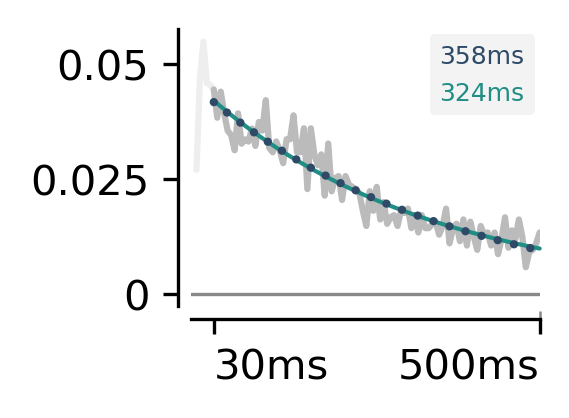

In [20]:
skip_content = False

# colors, single and two timescale fits
clr_1 = "#2E4A67"
clr_2 = "#208E85"


def fit_two_ts(rk):
    def _f_two_timescales(k, tau1, A1, tau2, A2):
        return np.abs(A1) * np.exp(-k / tau1) + np.abs(A2) * np.exp(-k / tau2)

    # tau1, A1, tau2, A2
    fitpars = np.array(
        [
            (0.1, 0.01, 10, 0.01),
            (0.1, 0.1, 10, 0.01),
            (0.5, 0.01, 10, 0.001),
            (0.5, 0.1, 10, 0.01),
            (0.1, 0.01, 10, 0),
            (0.1, 0.1, 10, 0),
            (0.5, 0.01, 10, 0),
            (0.5, 0.1, 10, 0),
        ]
    )

    fit = mre.fit(rk, fitpars=fitpars, fitfunc=_f_two_timescales)
    tau_1 = fit.popt[0]
    A_1 = np.abs(fit.popt[1])
    tau_2 = fit.popt[2]
    A_2 = np.abs(fit.popt[3])

    # Choose the timescale with higher coefficient A
    tau_selected = (tau_1, tau_2)[np.argmax((A_1, A_2))]
    tau_rejected = (tau_1, tau_2)[np.argmin((A_1, A_2))]
    A_selected = np.amax((A_1, A_2))
    A_rejected = np.amin((A_1, A_2))

    return {
        "fit": fit,
        "tau_selected": tau_selected,
        "A_selected": A_selected,
        "tau_rejected": tau_rejected,
        "A_rejected": A_rejected,
    }


def panel(binned_spt, tmin, tmax, ax=None):
    """
    create a single panel with C(T) and two fit approaches
    tmin, tmax in seconds

    needs some global variables to be defined (e.g. bin_size)
    """
    if not skip_content:
        # I know, we are recalculating this although we _should_ be able to mask after
        # calculatating rk. But way back I did not want to allow changing rks for safety.
        rk = mre.coefficients(
            mre.input_handler(binned_spt),
            method="ts",
            steps=(int(tmin / bin_size), int(tmax / bin_size)),
            dt=bin_size,
            dtunit=dtunit,
        )

        # it may be useful to see the rk that are cut away, at least on the left.
        rk_nf = mre.coefficients(
            mre.input_handler(binned_spt),
            method="ts",
            steps=(0, int(tmin / bin_size)),
            dt=bin_size,
            dtunit=dtunit,
        )

        # tau, A, O
        fitpars = np.array([(0.1, 0.01, 0), (0.1, 0.1, 0), (1, 0.01, 0), (1, 0.1, 0)])
        single_timescale_fit = mre.fit(rk, fitfunc="exponential_offset", fitpars=fitpars)

        _two_ts_fit = fit_two_ts(rk)
        two_timescales_fit = _two_ts_fit["fit"]
        tau_two_timescales = _two_ts_fit["tau_selected"]

        if ax is None:
            fig, ax = plt.subplots(figsize=(1.5, 1.2))
        else:
            fig = ax.get_figure()

        # rasterize the rks, to not kill pdf renderer!
        ax.set_rasterization_zorder(1.5)

        ax.plot(
            rk.steps * rk.dt,
            rk.coefficients,
            color="#BBB",
            solid_capstyle="round",
            zorder=1,
        )

        ax.plot(
            rk_nf.steps * rk_nf.dt,
            rk_nf.coefficients,
            color="#EEE",
            solid_capstyle="round",
            zorder=0.5,
        )

        fit = single_timescale_fit
        ax.plot(
            fit.steps * fit.dt,
            fit.fitfunc(fit.steps * fit.dt, *fit.popt),
            color=clr_1,
            solid_capstyle="round",
            dash_capstyle="round",
            ls=(0, (0.01, 2)),
            lw=2,
            clip_on=False,
            zorder=4,
        )
        log.debug(f"one timescales fit from {tmin} to {tmax}: {fit.popt}")

        fit = two_timescales_fit
        ax.plot(
            fit.steps * fit.dt,
            fit.fitfunc(fit.steps * fit.dt, *fit.popt),
            color=clr_2,
            lw=1.0,
            dash_capstyle="round",
            solid_capstyle="round",
            clip_on=False,
            zorder=3,
        )
        log.debug(f"two timescales fit from {tmin} to {tmax}: {fit.popt}")

        # indicate the zero
        ax.axhline(0, color="#888", lw=0.8, zorder=2)

        # ------------------------------------------------------------------------------ #
        # place fit results as text
        # ------------------------------------------------------------------------------ #

        # this works but overlaps lines
        # ax.text(
        #     0.95,
        #     0.95,
        #     (
        #         f"$\\tau_1$ = {single_timescale_fit.tau*1000:0f}ms\n$" +
        #         f"\\tau_2$ = {tau_two_timescales*1000:0f}ms"
        #     ),
        #     transform=ax.transAxes,
        #     va="top",
        #     ha="right",
        #     fontsize=6,
        #     color="#999",
        # )

        # workaround for automatic placement so that the annotation is readable:
        # https://stackoverflow.com/questions/7045729/automatically-position-text-box-in-matplotlib

        # create a list with two empty handles (or more if needed)
        handles = [
            mpl_patches.Rectangle((0, 0), 1, 1, fc="white", ec="white", lw=0, alpha=0)
        ] * 2

        # create the corresponding number of labels (= the text you want to display)
        t1 = single_timescale_fit.tau
        t2 = tau_two_timescales
        t1_str = ""
        t2_str = ""
        # t1_str += f"$\\tau_1$ "
        # t2_str += f"$\\tau_2$ "
        t1_str += f"{t1*1000:.0f}ms" if t1 < 1 else f"{t1:.1f}s"
        t2_str += f"{t2*1000:.0f}ms" if t2 < 1 else f"{t2:.1f}s"
        # we filter too large and too small values in our pipline, dont print those
        if t1 > 10:
            t1_str = f"> 10s"
        if t1 < 0:
            t1_str = f"< 0"
        if t2 > 10:
            t2_str = f"> 10s"
        if t2 < 0:
            t2_str = f"< 0"
        labels = [t1_str, t2_str]

        # create the legend, supressing the blank space of the empty line symbol and the
        # padding between symbol and label by setting handlelenght and handletextpad
        leg = ax.legend(
            handles,
            labels,
            # loc="best",
            # in the end, we decided to keep it in a fixed place that usually works
            loc="upper right",
            fontsize=6,
            # this effectively right-aligns our text
            markerfirst=False,
            fancybox=True,
            framealpha=0.7,
            handlelength=0,
            handletextpad=0,
            borderaxespad=0.2,
        )
        leg.get_frame().set_linewidth(0.0)
        leg.get_frame().set_color("#EEEEEE08")
        leg.get_texts()[0].set_color(clr_1)
        leg.get_texts()[1].set_color(clr_2)

    else:
        ax.plot(np.linspace(tmin, tmax, 20), np.linspace(tmin, tmax, 20), color="C0")

    # ax.set_ylim(0, None)
    # ax.set_xlim(tmin, tmax)
    ax.set_xlim(-3 / 1000, tmax)

    ax.set_xticks([tmin, tmax])
    ax.set_xticklabels(
        [
            # align first label to the left
            f"{int(tmin*1000)}ms" if tmin < 1 else f"{tmin:.1f}s",
            f"{tmax:.0f}s" if int(tmax) == tmax else f"{int(tmax*1000)}ms",
        ]
    )

    # add a minor tick at 500ms, pointing inwards.
    # offset by "nothing" to pretend mpl from hiding it because major tick at same pos
    ax.set_xticks([0.5 - 1e-5], minor=True)
    ax.tick_params(axis="x", which="minor", direction="in", color="#888")

    # avoid ugly 0.0000 ticks
    ax.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:g}"))

    return ax


# ------------------------------------------------------------------------------ #
# test single panel
# ------------------------------------------------------------------------------ #

unit = 950987340

merged_df.set_index("unit_id", inplace=True, drop=False)

binned_spt = utl.binned_spike_count(
    [merged_df.loc[unit]["spiketimes"].squeeze()], bin_size
)


ax = panel(binned_spt, tmin=0.03, tmax=0.5)

sns.despine(ax=ax, offset=3, trim=False)
ax.xaxis.get_major_ticks()[0].label1.set_horizontalalignment("left")
ax.xaxis.get_major_ticks()[1].label1.set_horizontalalignment("right")


2023-04-25 13:16:11,526 | INFO     | notebook     | row for unit 950913961, session 766640955, 2853 spikes ~ 2.64Hz


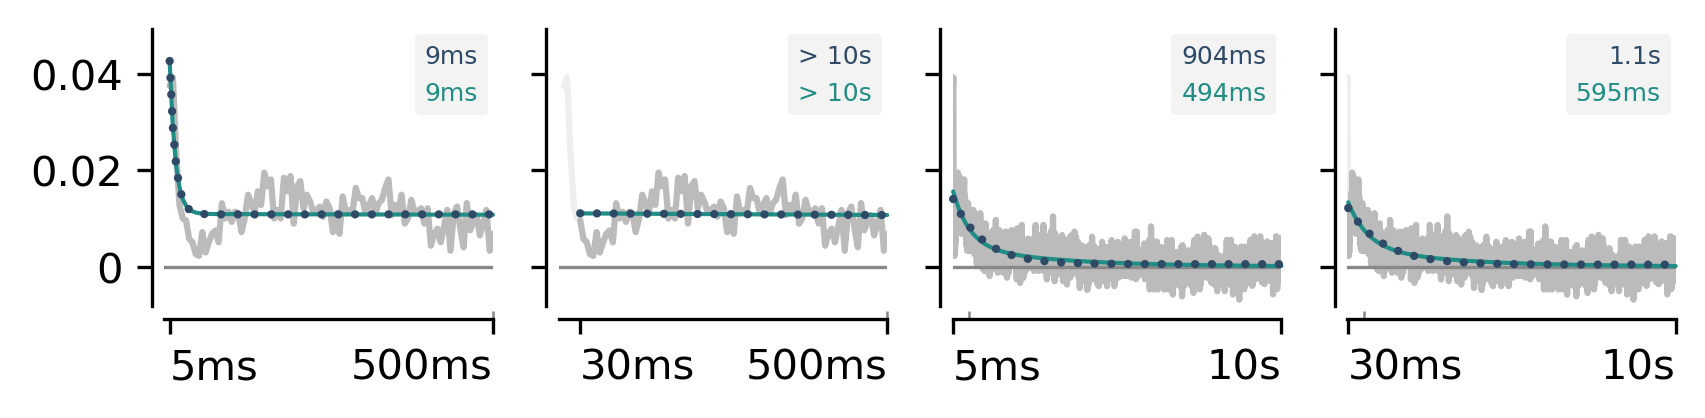

In [21]:
def row(rdx, df ,axes=None):
    # rdx is the row index in the provided dataframe, not the unit id
    # set index to units and blocks
    df = df.set_index(["block", "unit_id"], drop=False)

    unit = df.iloc[rdx]["unit_id"]
    session = df.iloc[rdx]["session"]
    num_spikes = df.iloc[rdx]["num_spikes"]
    firing_rate = df.iloc[rdx]["firing_rate"]

    log.info(f"row for unit {unit}, session {session}, {num_spikes} spikes ~ {firing_rate:.2f}Hz")

    binned_spt = utl.binned_spike_count(
        [df.iloc[rdx]["spiketimes"].squeeze()], bin_size
    )

    if axes is None:
        fig, axes = plt.subplots(1, 4, figsize=(6.5, 1.2))
    else:
        fig = axes[0].get_figure()

    panel(binned_spt, tmin=5/1000, tmax=0.5, ax=axes[0])
    panel(binned_spt, tmin=30/1000, tmax=0.5, ax=axes[1])
    panel(binned_spt, tmin=5/1000, tmax=10, ax=axes[2])
    panel(binned_spt, tmin=30/1000, tmax=10, ax=axes[3])

    y_max = max(ax.get_ylim()[1] for ax in axes) * 1.1
    y_min = min(ax.get_ylim()[0] for ax in axes) * 0.9
    for idx, ax in enumerate(axes):
        ax.set_ylim(y_min, y_max)
        if idx > 0:
            ax.tick_params(axis="y", labelleft=False)
    
        sns.despine(ax=ax, offset=3, trim=False)

        # redo the xtick alignment
        ax.xaxis.get_major_ticks()[0].label1.set_horizontalalignment('left')
        ax.xaxis.get_major_ticks()[1].label1.set_horizontalalignment('right')

    return axes

row(4, df=merged_df);

2023-04-25 13:16:21,526 | INFO     | notebook     | using units: [951041991, 950998243, 951185638, 951172354, 951126644, 950915735, 951137232, 951083667, 951031522, 951023128, 951126530, 951167102]
2023-04-25 13:16:22,070 | INFO     | notebook     | row 0
2023-04-25 13:16:22,075 | INFO     | notebook     | row for unit 951041991, session 778998620, 1527 spikes ~ 1.43Hz
2023-04-25 13:16:31,307 | INFO     | notebook     | row 1
2023-04-25 13:16:31,311 | INFO     | notebook     | row for unit 950998243, session 779839471, 5561 spikes ~ 5.15Hz
2023-04-25 13:16:40,708 | INFO     | notebook     | row 2
2023-04-25 13:16:40,712 | INFO     | notebook     | row for unit 951185638, session 847657808, 3893 spikes ~ 3.60Hz
2023-04-25 13:16:50,145 | INFO     | notebook     | row 3
2023-04-25 13:16:50,151 | INFO     | notebook     | row for unit 951172354, session 839068429, 11685 spikes ~ 10.81Hz
2023-04-25 13:16:59,734 | INFO     | notebook     | row 4
2023-04-25 13:16:59,738 | INFO     | notebook 

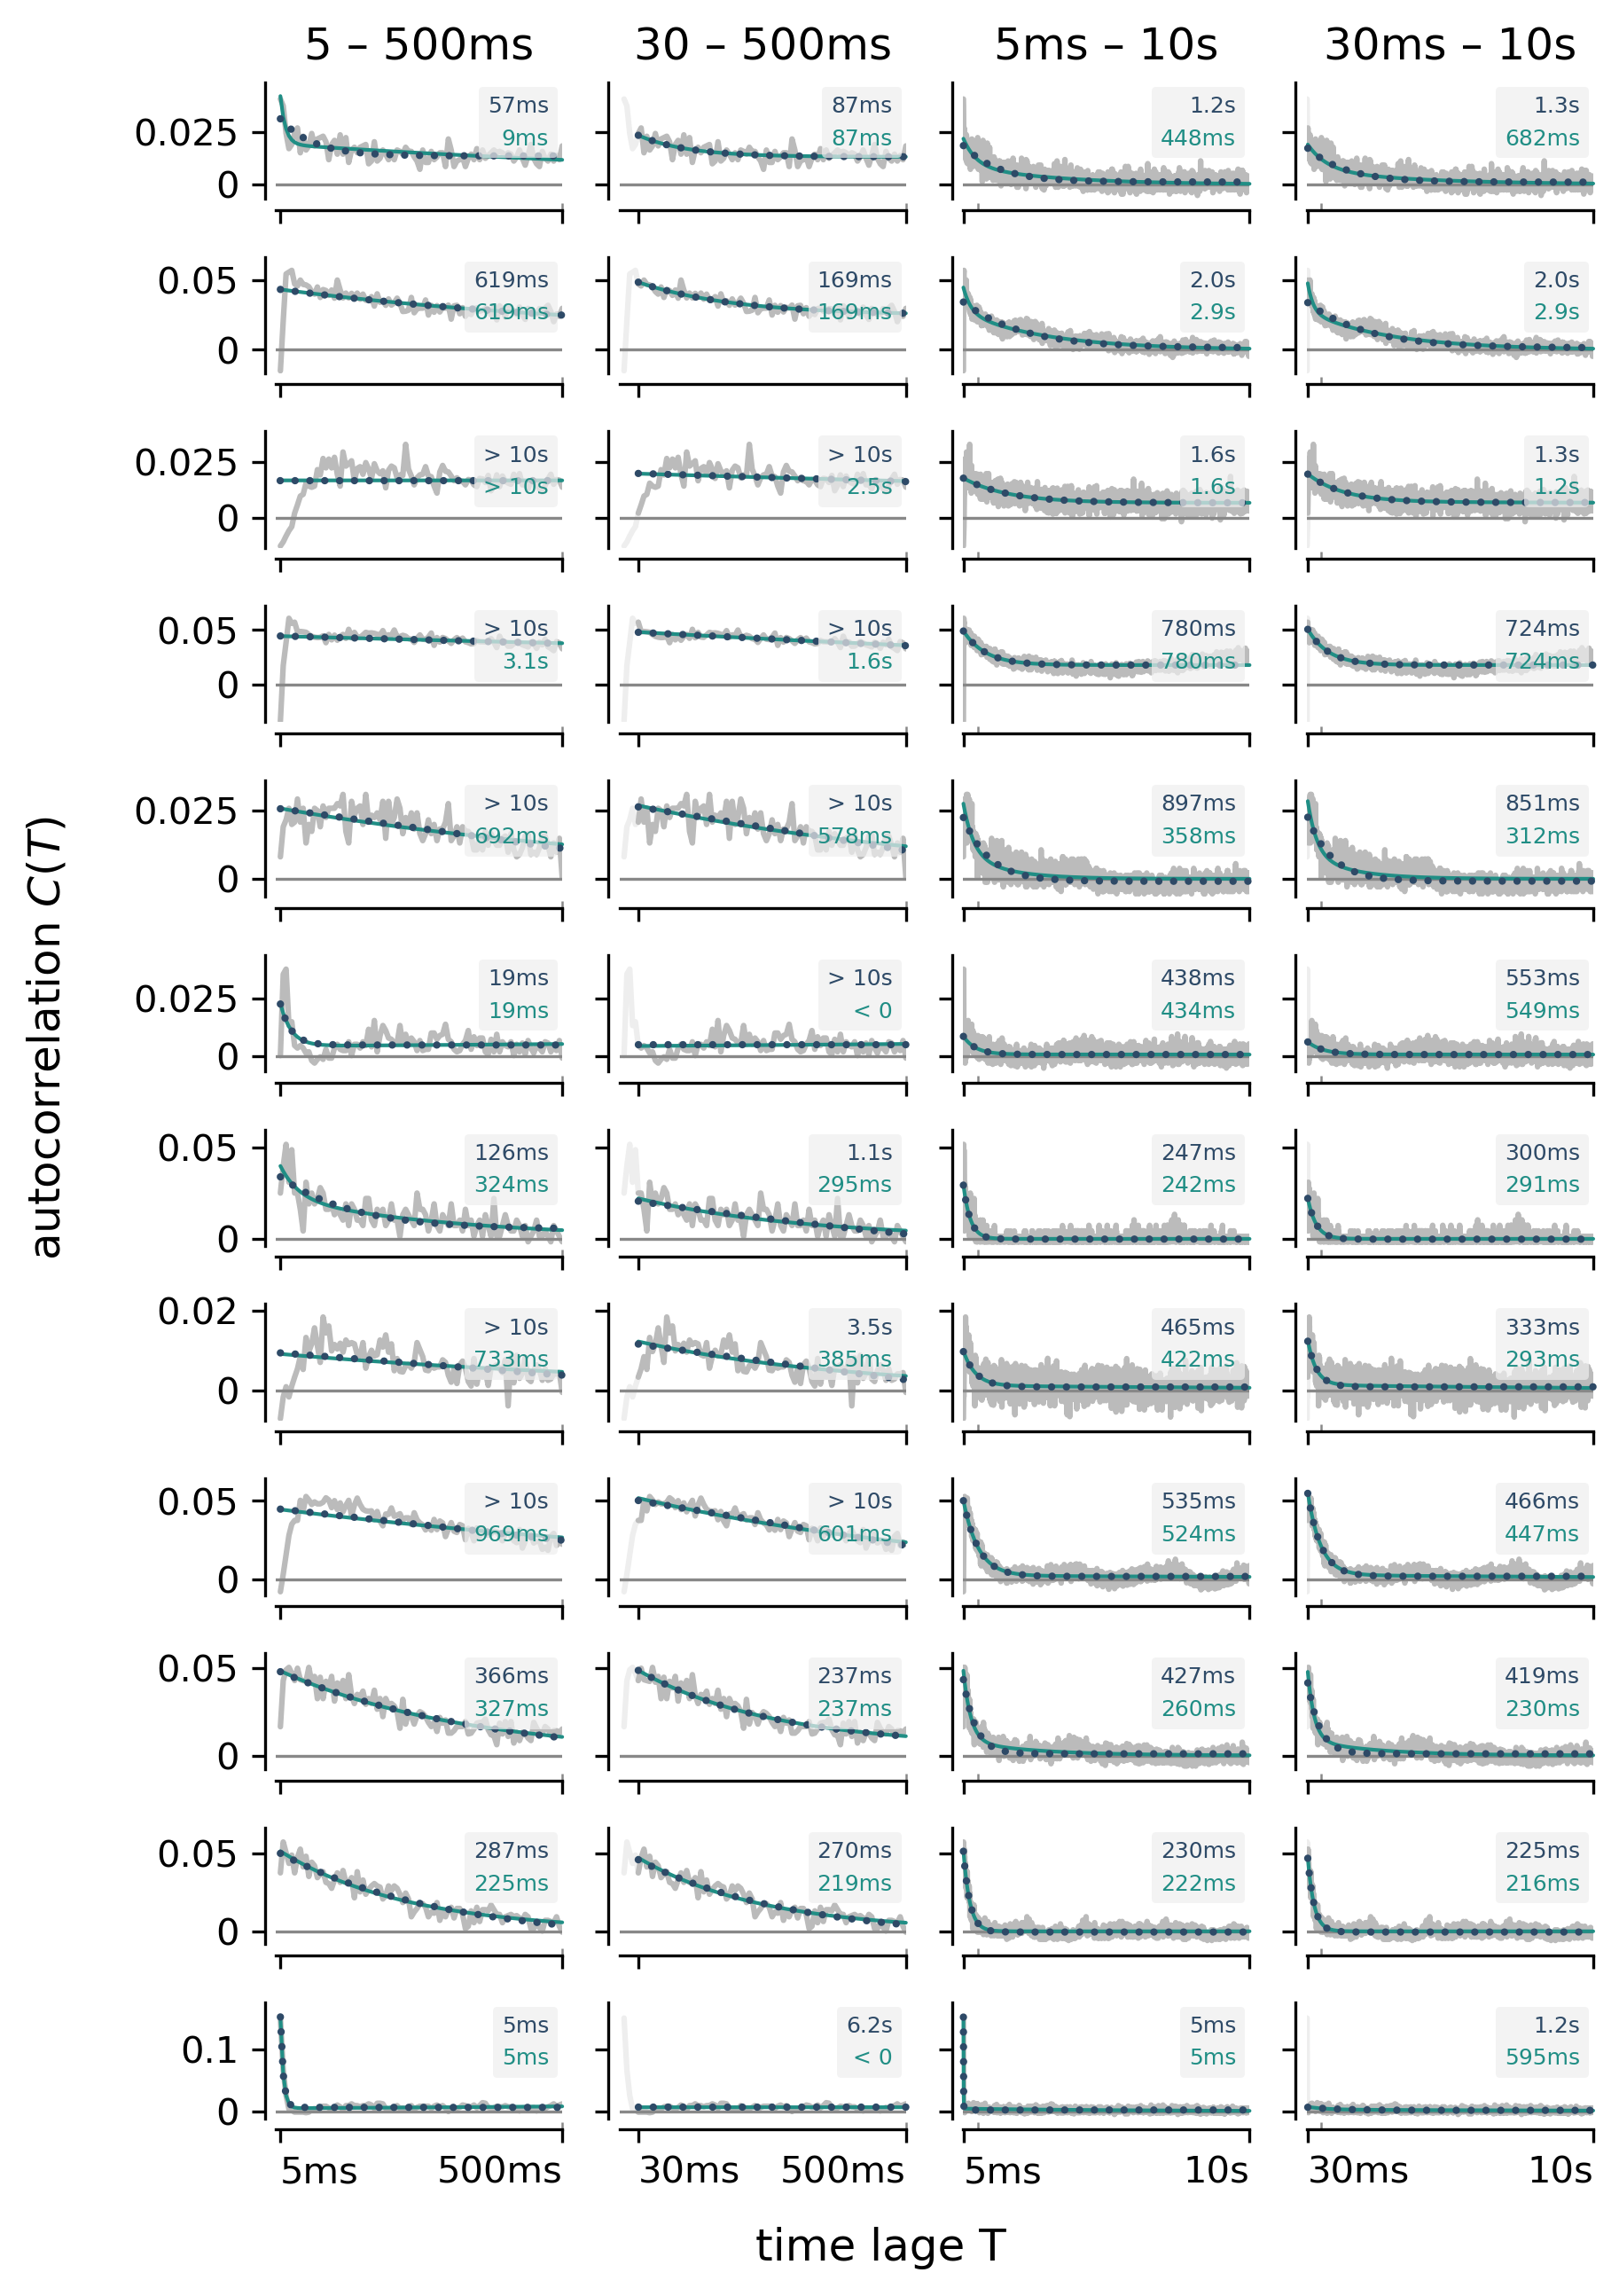

In [22]:
# Lets fill about an A4 page, leaving some space for margins and captions

page_width = 17 / 2.54
page_height = 24 / 2.54

num_cols = 4
num_rows = 12

# to test layout
skip_content = False

# create a selection of units
np.random.seed(28)
candidates = np.random.choice(np.arange(len(merged_df)), size=num_rows, replace=False)
log.info(f"using units: {[merged_df.iloc[c]['unit_id'] for c in candidates]}")

fig, axes = plt.subplots(
    num_rows,
    num_cols,
    figsize=(page_width, page_height),
    gridspec_kw=dict(wspace=0.2, hspace=0.5, bottom=0.07, left=0.16),
)

for row_idx in range(num_rows):
    log.info(f"row {row_idx}")
    row(candidates[row_idx], df=merged_df, axes=axes[row_idx, :])
    if row_idx == 0:
        axes[row_idx, 0].set_title("5 – 500ms")
        axes[row_idx, 1].set_title("30 – 500ms")
        axes[row_idx, 2].set_title("5ms – 10s")
        axes[row_idx, 3].set_title("30ms – 10s")
        
    if row_idx < num_rows - 1:
        for ax in axes[row_idx, :]:
            ax.tick_params(axis="x", labelbottom=False)

try:
    # requires matplotlib >= 3.4
    fig.supylabel(r'autocorrelation $C(T)$')
    fig.supxlabel(r'time lage T')
except:
    axes[-1, 0].set_ylabel(r'autocorrelation $C(T)$')
    axes[-1, -1].set_xlabel(r'time lage T')

fig.tight_layout()

In [24]:
merged_df.iloc[candidates[8]]

session                                                              778240327
stimulus                                        natural_movie_one_more_repeats
block                                                       merged_3.0_and_8.0
unit_id                                                              951031522
ecephys_structure_acronym                                                 VISl
invalid_spiketimes_check                                               SUCCESS
recording_length                                                   1081.035889
firing_rate                                                           4.622418
filepath                     /data.nst/share/data/allen_visual_coding_neuro...
num_spikes                                                                4997
spiketimes                   [<xarray.DataArray ()>\narray(0.10473633, dtyp...
Name: 951031522, dtype: object

In [23]:
fig.savefig(
    "/data.nst/pspitzner/information_timescales/paper_plots/img/"
    + "single_unit_fit_comparison_overivew.pdf",
    dpi=450,
    bbox_inches="tight",
)
